#Radiometer Experiment 2 - Stability

## Experimental setup

<img src="https://lh5.googleusercontent.com/-MQnV1zYcQWA/VKmzjJYKqYI/AAAAAAAB84E/1qX4x5rKVAQ/w977-h733-no/20150104_154121.jpg" alt="Drawing" style="width: 400px;"/>

Experiment 2 is used to help us establish that the system is stable is not fluctating greatly.  The experiment uses a 50 ohm matched load that is attached to the radiometer.  This matched load is then submerged into Liquid Nitrogen at ~ 77 K, for an extended period of time.   

## Software Defined Radio setup
The Software Defined Radio uses a N200 SDR from Ettus Research with GNURadio running a custom code for performing as a radiometer.  This program includes a GUI that allows for us to monitor the radiometer as well as control many of the properties of the radiometer such as frequency, bandwidth and integration time.  
<img src="https://lh6.googleusercontent.com/-8X3Tm3wyh-k/U-mZk_99UcI/AAAAAAAB5Vk/-Up_76efr7E/w1214-h759-no/Lab_0_Spectrum.png" alt="SDR" width=100%>

The program stores the total power data as a binary format which we can then load into a program such as Matlab or Python.  While we can also store the raw I/Q values as well, this results in data files that can be easily 20-40 GB in size for typical 10-15 minute experimental run.  The total power binary files are much smaller (usually less than 200 kB) and make it much easier to use.

The following table shows the configuration of the software defined radio and square-law detector.  This information is important as it let's us know the frequency, bandwidth and integration time.  We can use this information to calculate what the $NE\Delta T$ should be.

|Device  |Frequency  |Bandwidth  |Integration time
|--------|-----------------------
|N200    | 1406 MHz    |10 MHz or Msps| 2 seconds

## Square-law detector
For this experiment the square-law detector is not used.  This was done for two reasons.  One, our primary concern is with the software defined radio.  Second, the stability is impacted the most by the LNAs, so any change noted on the SDR would also be shown on the square-law detector.  Since our previous experiment proved that both the SDR and square-law detector are behaving as expected, we omitted the square-law detector.
- - -

Let's begin our analysis.  We will use Python to load the data files, parse them, analyse the data and graph the data.  All of this will take place within this iPython notebook.  

We begin with setting up our environment and importing required libraries.  Scipy allows us to read in the binary data files that GNURadio uses.  Numpy gives us access to a number of useful tools including graphing.  Finally csv allows us to read in and parse comma seperated files.  The calibration file we use is in a CSV format.

In [1]:
%matplotlib inline
from pylab import *

In [2]:
import scipy
import numpy
import scipy.io as sio
import csv

Use this to set the filename for the data file and CSV Calibration file.  We are not interested in square-law data nor do we need to calibrate the data as we are looking at overall trends.

In [3]:
tpr = 'SDR_TPR_EXP2.dat'
calib = 'calib.csv'

Uses SciPy to open the binary file from GNURadio

In [4]:
f = scipy.fromfile(open(tpr),dtype=scipy.float32)

Because of the valve function in GNURadio, there are zeros that get added to the file.  We want to trim out those zeros.

In [5]:
f = numpy.trim_zeros(f)

Create an index array for plotting.  Also, since we know the interval the data is taken, we can convert this to an actual time.

In [6]:
y = numpy.linspace(0,(len(f)*.5),numpy.size(f))

Before we begin, let's look at what we expect our performance to be.  This is our $NE\Delta T$ equation that we used in experiment 1 and the equations is below.

(1)  $$NE\Delta T=\frac{T_{A}+T_{sys}}{\sqrt{\beta  \tau}}$$

We will assume that our $T_{sys}$ is 420 Kelvin, which is based on information provided by the University of Michigan for the RF front we are using that they constructed.  We will ignore $T_{A}$ which is our antenna temperature due to the fact that we do not have an antenna hooked up and our matched load is our noise source.  $\beta$ is our bandwidth, which for the SDR is 10 MHz and for the square-law is 25 MHz.  Finally $\tau$ is our integration time, which we will use 2 seconds.  Let's plug these in and calculate for our setup

In [7]:
tau = 2
BSDR = 10e6
Tsys = 420

In [8]:
NEAT_SDR = Tsys/sqrt(BSDR*tau)

In [9]:
print NEAT_SDR

0.093914855055


Our $NE\Delta T$ is the same as in our previous experiment.  This is due to the fact that we kept the same bandwidth and integration time.  Therefore our $NE\Delta T$ is still calculated below 1 K.  

## Plot the data
We now want to plot the data.  Since we are interested in using these in my thesis, we will also configure matplotlib to use the $\LaTeX$ compiler so the graphs will insert nicely into the thesis.

In [10]:
matplotlib.rcParams.update({'font.size': 18, 'text.usetex': True})

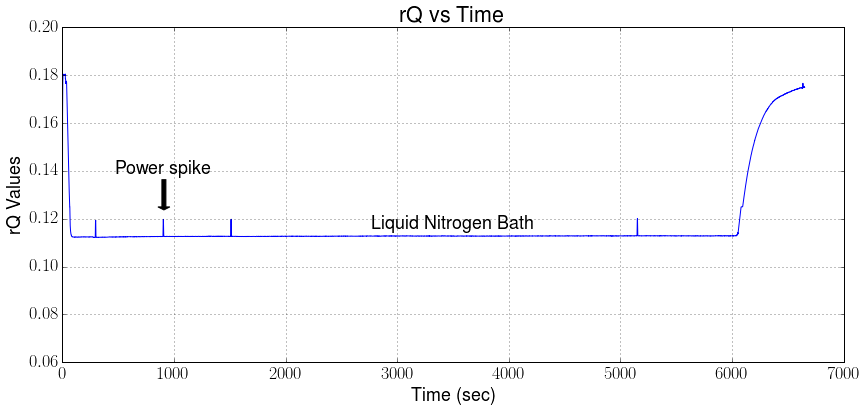

In [11]:
fig = plt.figure(figsize=(14,6), dpi=300)
ax = fig.add_subplot(111)
plot(y,f)
xlabel('Time (sec)')
ylabel('rQ Values')
title('rQ vs Time')
grid(True)
ax.annotate('Liquid Nitrogen Bath', xy=(.5, .41),  xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center')
ax.annotate('Power spike', xy=(.13, .45),  xycoords='axes fraction',
                xytext=(0.13, 0.6), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.05),
                horizontalalignment='center', verticalalignment='top',
                )
fig.savefig("sdr_rq_plot.pdf", dpi=300)
fig.savefig("sdr_rq_plot.png", dpi=300)

## Analyzing the data

We want to make sure the data is consistent over a period of time.  To do that we can look at the standard deviation of the data, specifically during the time that it is submerged in LN2.  

It can be seen in the graph above that we had a few spikes in the data.  In each case the data returned to normal values.  These spikes are probably cuased by an external influence, such as stray RF or slight fluctation in power.  However, we do have a solid one hour period that is free from any spikes.  We therefore focused on this area of the data to do our analysis.  Thefore we focus from 1520 seconds to 5,240 seconds.

- - -

In [12]:
#tstart = 1520;
#tstop = 5240;
tstart = 320;
tstop = 7540;
timeduration = (tstop-tstart)/60
print timeduration

120


This gives us two hours of data to work with.  

Since we now the data range that we want to work with now, let's trim out the rest of the data.

In [13]:
f = f[(tstart*2):]
f = f[:(tstop*1.37)]
y = y[(tstart*2):]
y = y[:(tstop*1.37)]

Now we can plot this data with the new time range of 1520 to 5240.  

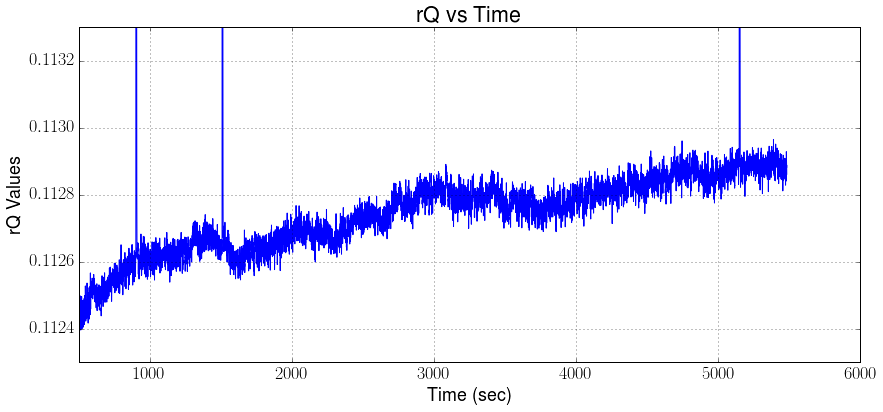

In [14]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(y,f)
xlabel('Time (sec)')
ylabel('rQ Values')
title('rQ vs Time')
axis([500, 6000, .1123, .1133])
grid(True)
fig.savefig("rq_plot_zoom.pdf", dpi=300)
fig.savefig("rq_plot_zoom.png", dpi=300)

Now let's do a standard deviation on this data and we also want to generate the points to do a polynominal fit to the data.

In [15]:
a = numpy.std(f)
print a
p = numpy.polyfit(y,f,2)
print p

0.000339949
[ -9.28353718e-12   1.29085196e-07   1.12467045e-01]


Since there is some noise in the signal, even with the integration there, let's do a polynominal fit to the data.  For the next graph we are using a second order polynominal fit to the data.

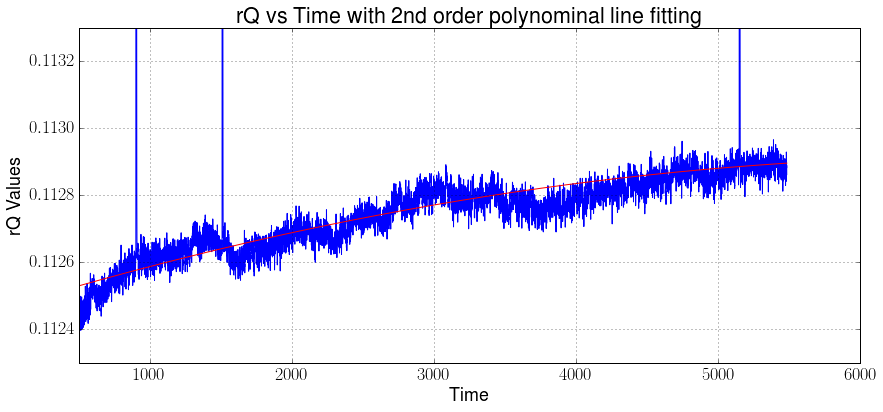

In [16]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(y,f)
plot(y,p[0]*y*y+p[1]*y+p[2],'r-')
xlabel('Time')
ylabel('rQ Values')
title('rQ vs Time with 2nd order polynominal line fitting')
grid(True)
axis([500, 6000, .1123, .1133])
fig.savefig("rq_line_fitting.pdf", dpi=300)
fig.savefig("rq_line_fitting.png", dpi=300)

Let's now look at the standard deviation with the data.  First we will smooth out the line and then plot the standard deviation on top of that line.

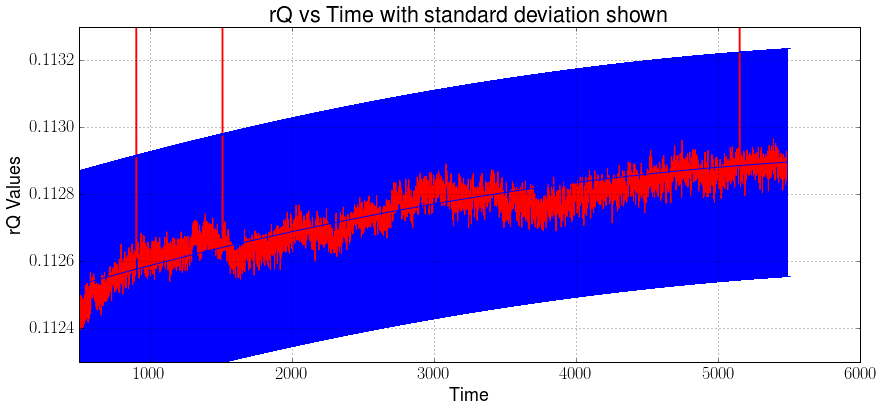

In [17]:
fig = plt.figure(figsize=(14,6), dpi=300)
b = p[0]*y*y+p[1]*y+p[2]
plot(y,f,'r-')
errorbar(y,b,a)
xlabel('Time')
ylabel('rQ Values')
title('rQ vs Time with standard deviation shown')
axis([500, 6000, .1123, .1133])
grid(True)
fig.savefig("rq_vstime_stddev.pdf", dpi=300)
fig.savefig("rq_vstime_stddev.png", dpi=300)

##Calibration

The rQ values are the raw values from the total power radiometer and are uncalibrated.  While the graph shows the change in the total power recorded and shows that the radiometer can detect changes in noise temperature, it has no other meaning than that.  What we want is to show what the total power is in relation to a noise temperature.  Since we have recorded the values of the rQ at fixed and known teperatures, we can create a calibration line and calibrate the radiometer.  For this experiment, we found that the following values matched our two known temperatures.

|rQ Value|Temperature
|--------|-----------------------
|.1243   |77 K
|.1730   |271.65 K

We can now solve for y = mx + b since we have two equations and two unknowns.

To work with this, a calibration file is created.  This is a very simple CSV file that contains 3 values: The raw rQ value, the raw voltage from the square-law detector (discussed later) and the observed temperature.  The table above would then look like the following in the file.
```
.1243,1.9846,77
.1730,2.1065,271.65
```
- - -

It should be noted that from here on out we will just use the LN2 and and ice water bath for our two points.  Because the square-law detector and the SDR have different sensitivities, it will mean that there will be an error when it goes outside of the calibration points.  Multiple points could be used, but traditionally we calibrate a radiometer to just two known points.  

We need to read in the values from our CSV file that contains the values

In [18]:
read_csv = open(calib, 'rb')
csvread = csv.reader(read_csv)
rQ_values = []
temp_values = []
voltage = []

for row in csvread:
    rQ,volt,temp = row
    rQ_values.append(float(rQ))
    voltage.append(float(volt))
    temp_values.append(float(temp))
read_csv.close()

In [19]:
a = numpy.array([[rQ_values[0],1.0],[rQ_values[1],1.0]],numpy.float32)
b = numpy.array([temp_values[0],temp_values[1]])

In [20]:
z = numpy.linalg.solve(a,b)
print z

[ 3013.15797425  -261.67896467]


In [21]:
g = f*z[0]+z[1]

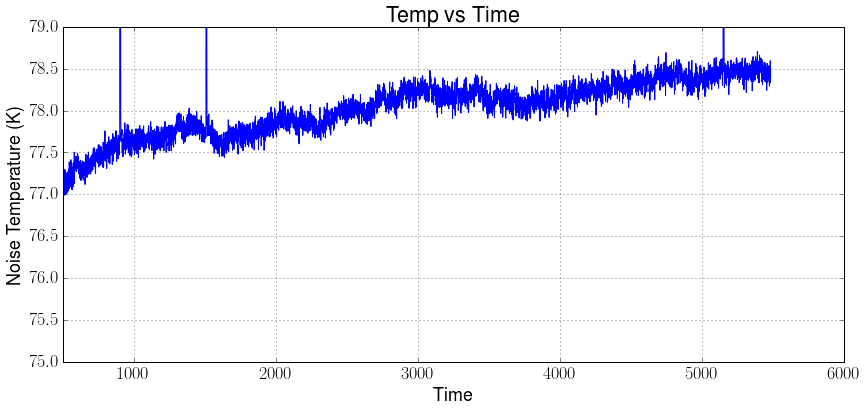

In [22]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(y,g)
xlabel('Time')
ylabel('Noise Temperature (K)')
title('Temp vs Time')
grid(True)
axis([500, 6000, 75, 79])
fig.savefig("sdr_calibrated_zoom.pdf", dpi=300)
fig.savefig("sdr_calibrated_zoom.png", dpi=300)

In [23]:
a = numpy.std(g)
print a
p = numpy.polyfit(y,g,2)
print p

1.02432
[ -2.79727061e-08   3.88953637e-04   7.72020161e+01]


The standard deviation is now calculated and gives us a standard deviation of about 1 Kelvin.  This is what we wanted from the system, so this shows that the SDR radiometer is stable over a long period of time of about 1 Kelvin.

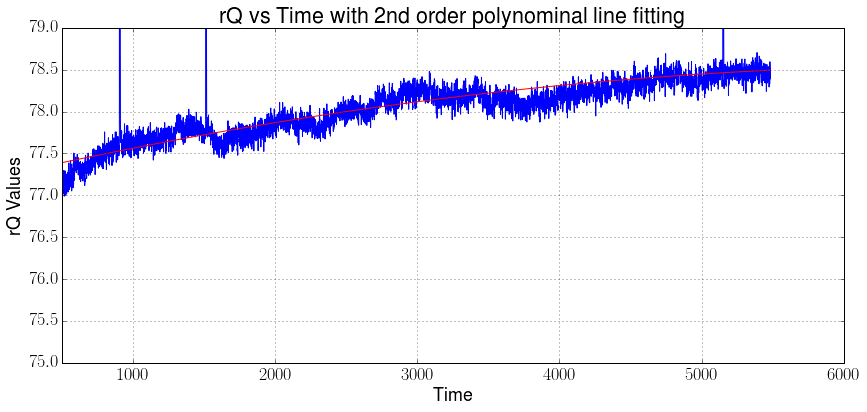

In [24]:
fig = plt.figure(figsize=(14,6), dpi=300)
plot(y,g)
plot(y,p[0]*y*y+p[1]*y+p[2],'r-')
xlabel('Time')
ylabel('rQ Values')
title('rQ vs Time with 2nd order polynominal line fitting')
axis([500, 6000, 75, 79])
grid(True)
fig.savefig("calib_line_fitting.pdf", dpi=300)
fig.savefig("calib_line_fitting.png", dpi=300)

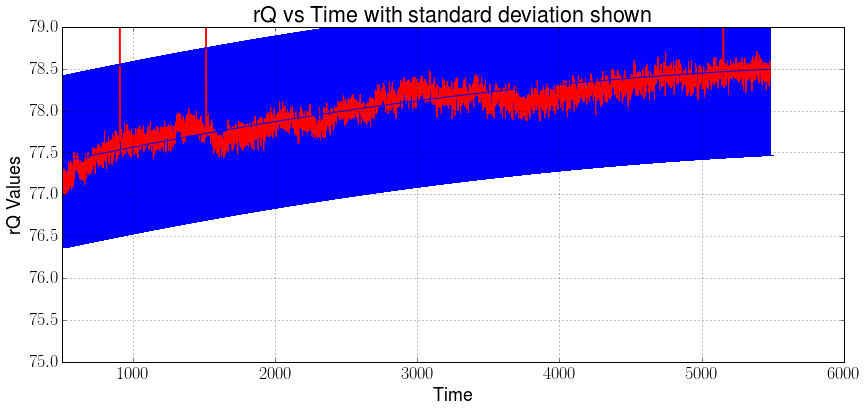

In [25]:
fig = plt.figure(figsize=(14,6), dpi=300)
b = p[0]*y*y+p[1]*y+p[2]
plot(y,g,'r-')
errorbar(y,b,a)
xlabel('Time')
ylabel('rQ Values')
title('rQ vs Time with standard deviation shown')
axis([500, 6000, 75, 79])
grid(True)
fig.savefig("calib_vstime_stddev.pdf", dpi=300)
fig.savefig("calib_vstime_stddev.png", dpi=300)

- - -
# Stability analysis

Stability is controlled primarily by the gain in the radiometer and is also affected by the overall system temperature as well.  It can be seen in the equation below how Gain, changes in gain and the system temperature affect our changes to gain and thus our stability in the radiometer.

$$\Delta T_{G}=T_{sys} \left(\frac{\Delta G}{G}\right)$$

We assume that our system temperature or $T_{sys}$ is constant.  Therefore our change in gain is our main driving force behind stability.  Changes to gain can happen due to two reasons.  First, we may have changes in the voltage that is being provided to the LNAs.  In our case, we are using a lab grade power supply where voltage ripple and changes should be tightly regulated.  Second, the physical temperature of the LNA also affects the amount of gain it provides.  This is harder to control, but in a lab environment can be at least monitored.  While the radiometer we are using does have thermal electric coolers that can also be used to regulate the temperature of the LNAs.  However they were disabled for these experiments due to suspicion that they were causing possible interference to the LNAs.  

By looking at the data above we have a standard deviation of $7.6 x 10^-6$ and an overal change of roughly .0003 for the rQ value.  Using calibrated data this roughly a change of 1 Kelvin.  This is what we expected of our $\Delta T$ of 1 Kelvin.